In [1]:
import numpy as np
import pandas as pd

from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle

from scipy import stats

from tensorflow.keras import Model, Input, layers, regularizers, optimizers, losses, metrics
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

C:\Users\crist\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


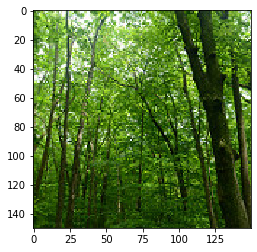

In [3]:
img = Image.open("scenes\\train\\8.jpg")
plt.imshow(img)
plt.show()

In [4]:
samples_df = pd.read_csv("scenes\\train.csv")
class_names = ['Forests','Mountains']
samples_df.head()

,image_name,label
0,0.jpg,0
1,1.jpg,4
2,2.jpg,5
3,4.jpg,0
4,7.jpg,4


In [5]:
samples_df["label"] = samples_df["label"].astype("str")
samples_df = samples_df[(samples_df.label == '1') | (samples_df.label == '2')].sample(frac=1)

In [6]:
img_means = []

for i in range(len(samples_df)):
    img = Image.open("scenes\\train\\" + samples_df.image_name.iloc[i])
    img = np.array(img)
    img_means.append(img.mean())
samples_df['Pixel Mean'] = np.array(img_means)

In [7]:
forests_df = samples_df[samples_df.label=='1']
mountains_df = samples_df[samples_df.label=='2']

forests_df = forests_df[np.abs(stats.zscore(forests_df['Pixel Mean'])) < 1]
mountains_df = mountains_df[np.abs(stats.zscore(mountains_df['Pixel Mean'])) < 1]

print('forest images: {}'.format(forests_df.shape[0]))
print('mountain images: {}'.format(mountains_df.shape[0]))

forest images: 1869
mountain images: 2075


In [8]:
select_df = shuffle(pd.concat([forests_df, mountains_df]),random_state=1)

In [9]:
training_percentage = 0.8
training_item_count = int(len(select_df)*training_percentage)
validation_item_count = len(select_df)-int(len(select_df)*training_percentage)
training_df = select_df[:training_item_count]
val_test_df = select_df[training_item_count:].sample(frac=1)
test_item_count = int(len(val_test_df)*(.5))
validation_df = val_test_df[:test_item_count]
test_df = val_test_df[:test_item_count]

In [10]:
batch_size = 32
image_size = 100
channels = 3
target_size = (image_size, image_size, )

train_datagen = ImageDataGenerator(rescale=1. / 255)
e_train_gen = train_datagen.flow_from_dataframe(
    dataframe = training_df,
    x_col='image_name',
    y_col='label',
    directory='scenes\\train\\',
    target_size=target_size,
    batch_size=batch_size,
    shuffle=True,
    class_mode='input')

validation_datagen = ImageDataGenerator(rescale=1. / 255)
e_val_gen = validation_datagen.flow_from_dataframe(
    dataframe = validation_df,
    x_col='image_name',
    y_col='label',
    directory='scenes\\train\\',
    target_size=target_size,
    shuffle=False,
    batch_size=batch_size,
    class_mode='input')

test_datagen = ImageDataGenerator(rescale=1. / 255)
e_test_gen = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    x_col='image_name',
    y_col='label',
    directory='scenes\\train\\',
    target_size=target_size,
    shuffle=False,
    batch_size=batch_size,
    class_mode='categorical')

Found 3155 validated image filenames.
Found 394 validated image filenames.
Found 394 validated image filenames belonging to 2 classes.


In [11]:
imgs = []
truth = []
for i in range(32):    
    examples = e_test_gen.next()
    images = imgs.append(examples[0])
    truth.append(examples[1])

img_array = np.vstack([imgs[0],imgs[1]])
truth_array = np.vstack([truth[0],truth[1]])

for i in range(len(imgs)-2):
    img_array = np.vstack([img_array,imgs[i+2]])
    truth_array = np.vstack([truth_array,truth[i+2]])

labels = [np.where(r==1)[0][0] for r in truth_array]

classes = []
for i in range(len(labels)):
    classes.append(class_names[labels[i]])

In [12]:
#helpers
class Sampling(layers.Layer):
    #uses z_mean, z_log_var to sample z, encoding vector
    
    def call(self, z_mean, z_log_var):
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch,dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def kl_divergence(z_mean, z_log_var):
    kl_loss = -0.5*(1+z_log_var-tf.square(z_mean)-tf.exp(z_log_var))
    return tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

def reconstruction_loss(real, reconstruction):
    return tf.reduce_mean(tf.reduce_sum(
        losses.binary_crossentropy(real, reconstruction), axis=(1,2)))

In [17]:
#begin VAE code
latent_dim = 2

#**********ENCODER**********#
E_input = Input(shape=(image_size,image_size,channels))

x = layers.Conv2D(32, 3, strides=2,
                         activation='relu',padding='same',
                         kernel_initializer='orthogonal',
                         kernel_regularizer=regularizers.l2(2e-3))(E_input)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, strides=2,
                         activation='relu',padding='same',
                         kernel_initializer='orthogonal',
                         kernel_regularizer=regularizers.l2(2e-3))(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(128, 3, strides=2,
                         activation='relu',padding='same',
                         kernel_initializer='orthogonal',
                         kernel_regularizer=regularizers.l2(2e-3))(x)
x = layers.MaxPooling2D()(x)

x = layers.Flatten()(x)

z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

z = Sampling()(z_mean, z_log_var)

encoder = Model(E_input, [z_mean, z_log_var, z])

#KL Divergence
encoder.add_loss(kl_divergence(z_mean, z_log_var))

#**********DECODER**********#
D_input = Input(shape=(latent_dim,))

y = layers.Dense(5 * 5 * 8, activation='relu')(D_input)
y = layers.Dense(25 * 25 * 64, activation='relu')(y)

y = layers.Reshape((25, 25, 64))(y)

y = layers.Conv2DTranspose(32, 3, strides=2,
                                  activation='relu', padding='same',
                                  kernel_initializer='orthogonal',
                                  kernel_regularizer=regularizers.l2(2e-3))(y)
D_output = layers.Conv2DTranspose(3, 3, strides=2,
                                 activation='relu', padding='same',
                                 kernel_initializer='orthogonal',
                                 kernel_regularizer=regularizers.l2(2e-3))(y)

decoder = Model(D_input, D_output)

z_mean, z_log_var, z = encoder(E_input)
decoder_output = decoder(z)

vae = Model(E_input, decoder_output)

In [18]:
vae.compile(optimizer=optimizers.Adam(), 
            loss=reconstruction_loss,
            metrics=['mse'])

In [19]:
#sample encoder before training
pretrain_encodings = encoder(img_array)[2].numpy()

In [20]:
history = vae.fit(e_train_gen,
                  validation_data=e_val_gen,
                  epochs=20)

Epoch 1/20
99/99 [==============================] - 3s 25ms/step - loss: 10430.7217 - mse: 0.1125 - val_loss: 6679.2886 - val_mse: 0.0633
Epoch 2/20
99/99 [==============================] - 2s 22ms/step - loss: 6605.1646 - mse: 0.0595 - val_loss: 6554.6045 - val_mse: 0.0580
Epoch 3/20
99/99 [==============================] - 2s 22ms/step - loss: 6518.9756 - mse: 0.0559 - val_loss: 6474.2842 - val_mse: 0.0548
Epoch 4/20
99/99 [==============================] - 2s 22ms/step - loss: 6416.2129 - mse: 0.0513 - val_loss: 6377.4399 - val_mse: 0.0504
Epoch 5/20
99/99 [==============================] - 2s 22ms/step - loss: 6351.8384 - mse: 0.0484 - val_loss: 6343.6904 - val_mse: 0.0490
Epoch 6/20
99/99 [==============================] - 2s 22ms/step - loss: 6349.8599 - mse: 0.0484 - val_loss: 6333.4282 - val_mse: 0.0484
Epoch 7/20
99/99 [==============================] - 2s 22ms/step - loss: 6316.6118 - mse: 0.0470 - val_loss: 6315.5806 - val_mse: 0.0478
Epoch 8/20
99/99 [======================

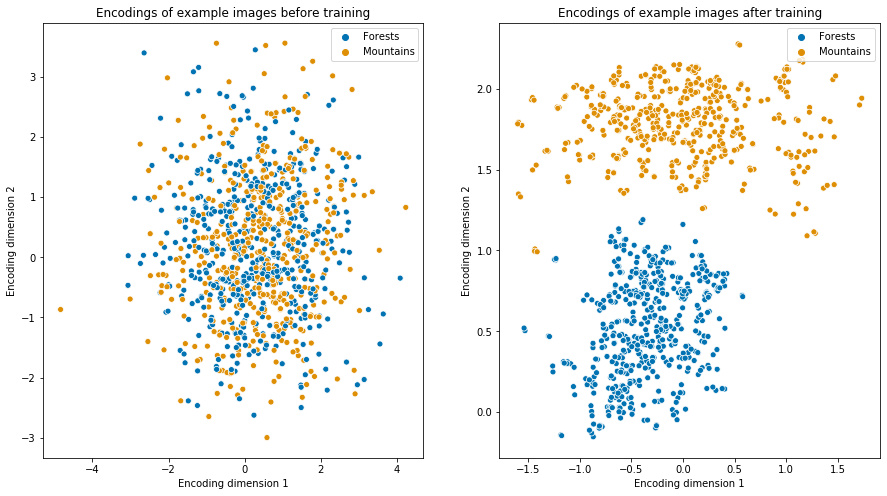

In [21]:
posttrain_encodings = encoder(img_array)[2].numpy()

f, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
sns.scatterplot(pretrain_encodings[:, 0],
                pretrain_encodings[:, 1],
                hue=classes, ax=axs[0],
                palette=sns.color_palette("colorblind", 2));
sns.scatterplot(posttrain_encodings[:, 0],
                posttrain_encodings[:, 1],
                hue=classes, ax=axs[1],
                palette=sns.color_palette("colorblind", 2));

axs[0].set_title('Encodings of example images before training');
axs[1].set_title('Encodings of example images after training');

for ax in axs: 
    ax.set_xlabel('Encoding dimension 1')
    ax.set_ylabel('Encoding dimension 2')
    ax.legend(loc='upper right')
    
f.savefig('plots\\mf_vae_before_after_mean_1.jpg')

In [22]:
training_percentage = 0.8
training_item_count = int(len(samples_df)*training_percentage)
validation_item_count = len(samples_df)-int(len(samples_df)*training_percentage)
training_df = samples_df[:training_item_count]
val_test_df = samples_df[training_item_count:].sample(frac=1)
test_item_count = int(len(val_test_df)*(.5))
validation_df = val_test_df[:test_item_count]
test_df = val_test_df[:test_item_count]

In [23]:
train_datagen = ImageDataGenerator(rescale=1. / 255)
c_train_gen = train_datagen.flow_from_dataframe(
    dataframe = training_df,
    x_col='image_name',
    y_col='label',
    directory='scenes\\train\\',
    target_size=target_size,
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical')

validation_datagen = ImageDataGenerator(rescale=1. / 255)
c_val_gen = validation_datagen.flow_from_dataframe(
    dataframe = validation_df,
    x_col='image_name',
    y_col='label',
    directory='scenes\\train\\',
    target_size=target_size,
    shuffle=False,
    batch_size=batch_size,
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
c_test_gen = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    x_col='image_name',
    y_col='label',
    directory='scenes\\train\\',
    target_size=target_size,
    shuffle=False,
    batch_size=batch_size,
    class_mode='categorical')

Found 4561 validated image filenames belonging to 2 classes.
Found 570 validated image filenames belonging to 2 classes.
Found 570 validated image filenames belonging to 2 classes.


In [24]:
encoder.trainable = False

z_mean, z_log_var, z = encoder(E_input,training=False)

z = layers.Dense(64,activation='relu')(z)
z = layers.Dense(16,activation='relu')(z)
z = layers.Dropout(.25)(z)
out = layers.Dense(2,activation='sigmoid')(z)

classifier = Model(E_input,out)

In [25]:
classifier.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
model_3 (Functional)         [(None, 2), (None, 2), (N 93764     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_5 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 34        
Total params: 95,030
Trainable params: 1,266
Non-trainable params: 93,764
___________________________________________________

In [26]:
classifier.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=[metrics.BinaryAccuracy()])

In [27]:
classifier_history = classifier.fit(c_train_gen, epochs=10, validation_data=c_val_gen)

Epoch 1/10
143/143 [==============================] - 3s 20ms/step - loss: 8.5311 - binary_accuracy: 0.7188 - val_loss: 8.2757 - val_binary_accuracy: 0.8632
Epoch 2/10
143/143 [==============================] - 3s 19ms/step - loss: 8.2870 - binary_accuracy: 0.8747 - val_loss: 8.1203 - val_binary_accuracy: 0.9140
Epoch 3/10
143/143 [==============================] - 3s 19ms/step - loss: 8.2220 - binary_accuracy: 0.9091 - val_loss: 8.1012 - val_binary_accuracy: 0.9316
Epoch 4/10
143/143 [==============================] - 3s 19ms/step - loss: 8.2137 - binary_accuracy: 0.9126 - val_loss: 8.0998 - val_binary_accuracy: 0.9272
Epoch 5/10
143/143 [==============================] - 3s 19ms/step - loss: 8.2132 - binary_accuracy: 0.9139 - val_loss: 8.0935 - val_binary_accuracy: 0.9307
Epoch 6/10
143/143 [==============================] - 3s 19ms/step - loss: 8.2084 - binary_accuracy: 0.9146 - val_loss: 8.0960 - val_binary_accuracy: 0.9298
Epoch 7/10
143/143 [==============================] - 3s 1

In [28]:
classifier.evaluate(c_test_gen)

18/18 [==============================] - ETA: 0s - loss: 8.0764 - binary_accuracy: 0.930 - 0s 17ms/step - loss: 8.0916 - binary_accuracy: 0.9333


[8.091647148132324, 0.9333333373069763]